In [1]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

from lib.i_o import read_csv

In [2]:
df_x_train = read_csv("X_train.csv", "../data/")
df_y_train = read_csv("y_train.csv", "../data/")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [3]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 833
#observations: 1212


In [4]:
# df_y_train.set_index('id', inplace=True)
# df_x_train.set_index('id', inplace=True)

In [5]:
from sklearn import preprocessing
df_impute_before = df_x_train.drop(columns='id')
# scaler = preprocessing.RobustScaler().fit(df_impute_before)
# df_impute_before = pd.DataFrame(scaler.transform(df_impute_before))

In [6]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

if 'id' in df_impute_before.columns: 
    df_impute_before = df_impute_before.drop(columns='id')

imp = SimpleImputer(missing_values=np.nan)
imp.fit(df_impute_before)
df_x_train_imputed = pd.DataFrame(imp.transform(df_impute_before))

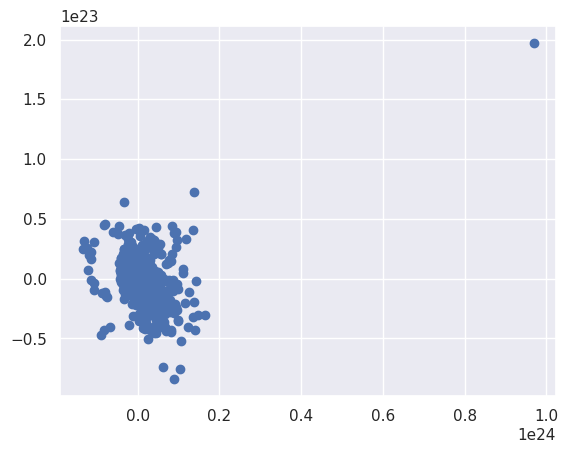

In [7]:
# EDA for outliers
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# pca.fit(df_x_train_imputed.drop(columns=['y']))
pca.fit(df_x_train_imputed)
X_pca_before = pca.transform(df_x_train_imputed)

plt.scatter(X_pca_before[:, 0], X_pca_before[:, 1]);

In [8]:
# Detect out / inliers
from sklearn.ensemble import IsolationForest
X = np.array(df_x_train_imputed)
clf = IsolationForest(n_estimators=8, warm_start=True)
clf.fit(X)  

isof_pred = clf.predict(X)
print("Outliers = -1, Inliers = 1")
pd.Series(isof_pred).value_counts()

Outliers = -1, Inliers = 1


 1    1129
-1      83
dtype: int64

In [9]:
# Join out / inlier column
df_x_train_imputed['isof_cat'] = isof_pred
df_x_train_imputed['is_inlier'] = df_x_train_imputed['isof_cat'] == 1
df_x_train_imputed['is_inlier'].value_counts()

True     1129
False      83
Name: is_inlier, dtype: int64

In [10]:
# Join y column
df_x_train_imputed['id'] = df_x_train['id']
if 'y' not in df_x_train_imputed.columns: 
    df_x_train_imputed = df_x_train_imputed.merge(df_y_train, how='left', left_on='id', right_on='id')

In [11]:
# Remove outliers
df_x_train_inliers = df_x_train_imputed[df_x_train_imputed['is_inlier']].drop(columns=['id', 'is_inlier', 'isof_cat'])

In [12]:
# Prepare data for splitting
X = df_x_train_inliers.drop(columns='y')
y = df_x_train_inliers['y']

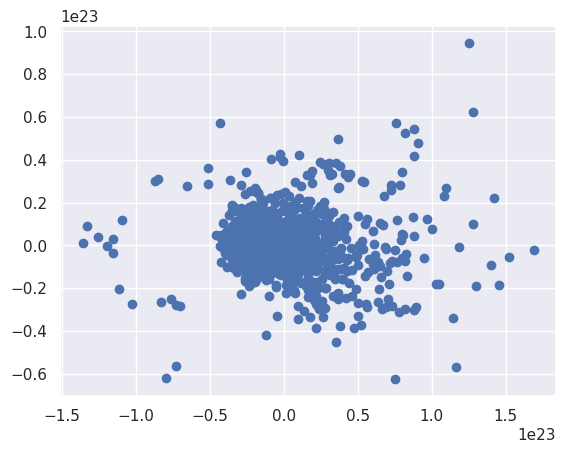

In [13]:
# Check outlier detection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# pca.fit(df_x_train_imputed.drop(columns=['y']))
pca.fit(df_x_train_inliers.drop(columns=['y']))
X_pca = pca.transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1]);

In [14]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) 

In [15]:
# Standardize features
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [16]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,1.714085,4.201841,1.028440,2.453370,-1.187049,-0.084393,-0.773595,-0.875709,0.466973,0.960482,...,-0.452330,2.348567,-0.657813,1.775378,-0.364039,0.630316,0.004672,0.907719,0.400772,1.095118
1,-1.044885,0.505517,0.149748,0.872638,-0.128256,-0.331151,0.529757,-0.406249,-0.045108,1.436951,...,-0.958185,-0.219523,0.319799,0.641847,-1.351740,0.414420,0.170425,1.283063,1.557618,1.975499
2,-0.008014,0.094745,0.724247,0.814136,-0.566874,-0.633160,-0.124318,0.980627,1.126720,-0.399505,...,0.952498,0.831288,-0.634646,-1.625300,0.251813,-0.927861,1.143271,-0.338074,-0.033553,-0.949424
3,0.239299,1.417492,0.590614,0.432372,-1.605154,0.453344,0.459170,0.317989,-1.227491,1.183412,...,-0.899364,-0.579746,0.657250,0.384700,-1.701492,-0.005963,-0.496692,-0.272974,1.523035,0.490486
4,-0.550957,-0.538208,-0.371128,0.018056,0.870046,-1.650208,0.106677,1.492907,-1.281234,-1.646939,...,-1.587011,-0.592226,0.576110,-0.933148,0.156470,0.312426,-0.070575,-0.178708,-1.176018,-0.336778


In [17]:
# Train regression model
from sklearn import linear_model
from sklearn.linear_model import LassoCV
reg_model = LassoCV(cv=20, random_state=92, n_jobs=-1, selection="random", max_iter=10000)
# reg_model = linear_model.Lasso(alpha=0.7, random_state=92, selection="random", max_iter=10000) # 0.45
reg = reg_model.fit(X_train_scaled, y_train)

In [18]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LinearRegression

# model = SelectFromModel(reg_model, prefit=True)
# X_train_selected = model.transform(X_train_scaled)
# X_val_selected = model.transform(X_val_scaled)
# reg_model_selected = LinearRegression().fit(X_train_selected, y_train)

In [19]:
coeffs = pd.Series(reg_model.coef_)
print(coeffs.describe(), end='\n\n')

print("-----------------------------------")
print(f"# non zero coefficients {(coeffs != 0).sum()}")
# print(f"Alpha {round(reg.alpha_, 3)}")

count    832.000000
mean      -0.003048
std        0.127630
min       -1.153182
25%        0.000000
50%        0.000000
75%        0.000000
max        1.766750
dtype: float64

-----------------------------------
# non zero coefficients 123


In [20]:
# Non zero coefficients
coeffs[(coeffs != 0)]

2     -0.022884
6     -0.171491
12    -0.275947
24    -0.082725
31     0.085008
         ...   
811   -0.045247
812    0.025713
819   -0.125902
827    0.602234
828    0.626478
Length: 123, dtype: float64

In [21]:
# Make predictions
try:
    train_pred_previous = np.array(train_pred, copy=True)
except: 
    print("train_pred is not defined, probably")
    train_pred_previous = np.array([])
train_pred = reg.predict(X_train_scaled)
print(f"Training predictions unchanged: {np.array_equal(train_pred, train_pred_previous)}")
val_pred = reg.predict(X_val_scaled)
# train_pred_selected = reg_model_selected.predict(X_train_selected)
# val_pred_selected = reg_model_selected.predict(X_val_selected)

train_pred is not defined, probably
Training predictions unchanged: False


In [22]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

Training score 0.583
Validation score 0.387


Training score 0.44  
Test score 0.505

<Axes: xlabel='y'>

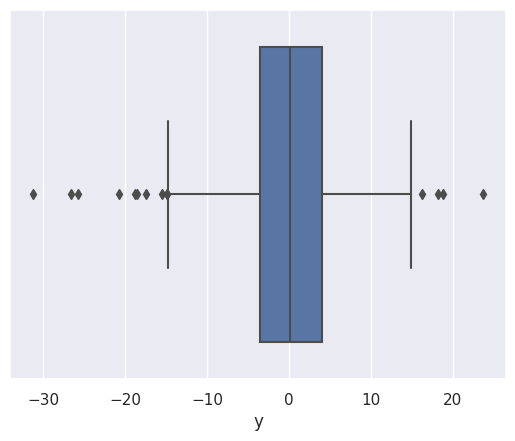

In [23]:
sns.boxplot(x=(y_train - train_pred))

<Axes: xlabel='y'>

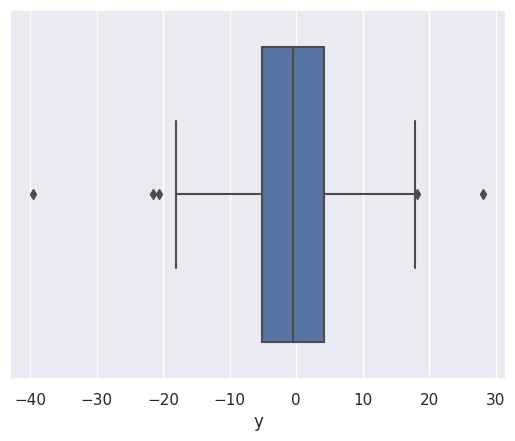

In [24]:
sns.boxplot(x=(y_val - val_pred))